In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
from zipfile import ZipFile
import sys
from contextlib import contextmanager
import time
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
@contextmanager 
def timer(name: str, _align): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [3]:
def cal_indicators(tabular_df, indicator_name, parameters):
    if indicator_name == "MA":
        assert len(slice_win_size) == 1, f'Wrong parameters num, expected 1, got {len(parameters)}'
        slice_win_size = parameters[0]
        MA = tabular_df['close'].rolling(slice_win_size, min_periods=1).mean()
        return MA # pd.Series

In [6]:
def single_symbol_image(tabular_df, image_size, start_date, sample_rate, indicators={}, show_volume=False):
    ''' generate Candlelist images
    
    parameters: [
        tabular_df -> pandas.DataFrame: tabular data,
        image_size -> tuple: (H, W), size shouble (32, 15) or (64, 60),
        start_date -> int: truncate extra rows after generating images,
        (!use default now) sample_rate -> float: for each stock, while iterate trading dates, randomly skip some dates to decrease datasize,
        (!use default now) indicators -> dict: technical indicators added on the image, e.g. {"MA": params}, {"VOLUME": params}
    ]
    
    Note: A single day's data occupies 3 pixel (width). First rows's dates should be prior to the start date in order to make sure there are enough data to generate image for the start date.
    
    return -> list: each item of the list is [np.array(image_size), binary, binary, binary]. The last three binary (0./1.) are the label of ret1, ret5 and ret20
    
    '''
    for ind in indicators.keys():
        tabular_df[ind] = cal_indicators(tabular_df, ind, indicators[ind])
    
    dataset = []
    lookback = image_size[1]//3
    for d in range(lookback-1, len(tabular_df)):
        # random skip some trading dates
        if np.random.rand(1) > sample_rate:
            continue
        # skip dates before start_date
        if tabular_df.iloc[d]['date'] < start_date:
            continue
        
        price_slice = tabular_df[d-(lookback-1):d+1][['open', 'high', 'low', 'close']+list(indicators.keys())].reset_index(drop=True)
        
        # no transactions recently
        if np.max(price_slice.values) == np.min(price_slice.values): 
            continue
        
        # project price into quantile
        price_slice = (price_slice - np.min(price_slice.values))/(np.max(price_slice.values) - np.min(price_slice.values))
        if not show_volume:
            price_slice = price_slice.apply(lambda x: x*(image_size[0]-1)).astype(int)
        
        image = np.zeros(image_size)
        for i in range(len(price_slice)):
            image[price_slice.loc[i]['open'], i*3] = 255.
            image[price_slice.loc[i]['low']:price_slice.loc[i]['high']+1, i*3+1] = 255.
            image[price_slice.loc[i]['close'], i*3+2] = 255.
    
        label_ret1 = 1 if np.sign(tabular_df.iloc[d]['ret1']) > 0 else 0
        label_ret5 = 1 if np.sign(tabular_df.iloc[d]['ret5']) > 0 else 0
        label_ret20 = 1 if np.sign(tabular_df.iloc[d]['ret20']) > 0 else 0
        
        entry = [image, label_ret1, label_ret5, label_ret20]
        dataset.append(entry)
    return dataset


class ImageDataSet():
    def __init__(self, win_size, start_date, end_date, mode, sample_rate, indicators={}, show_volume=False):
        assert mode in ['train', 'test'], f'Type Error: {mode}'
        assert win_size in [5, 20], f'Wrong look back days: {win_size}'
        
        if win_size == 5:
            self.image_size = (32, 15)
        else:
            self.image_size = (64, 60)
            
        self.start_date = start_date
        self.end_date = end_date 
        self.mode = mode
        self.sample_rate = sample_rate
        self.indicators = indicators
        self.show_volume = show_volume
        self.load_data()
        print(f"{self.mode.upper()} DataSet Initialized\n \t - Image Size:   {self.image_size}\n \t - Time Period:  {self.start_date} - {self.end_date}\n \t - Sample Rate:  {self.sample_rate}\n \t - Indicators:   {self.indicators}\n \t - Volume Shown: {self.show_volume}")
        # self.generate_images()
        
    @timer('Load Data', '8')
    def load_data(self):
        if 'data' not in os.listdir():
            print('Download Original Tabular Data')
            os.system("mkdir data && cd data && wget 'https://cloud.tsinghua.edu.cn/f/f0bc022b5a084626855f/?dl=1' -O tabularDf.zip")
            
        if 'data' in os.listdir() and 'tabularDf.zip' not in os.listdir('data'):
            print('Download Original Tabular Data')
            os.system("cd data && wget 'https://cloud.tsinghua.edu.cn/f/f0bc022b5a084626855f/?dl=1' -O tabularDf.zip")
        
        with ZipFile('data/tabularDf.zip', 'r') as z:
            f =  z.open('tabularDf.csv')
            tabularDf = pd.read_csv(f, index_col=0)
            f.close()
            z.close()
            
        # add extra rows to make sure image of start date and returns of end date can be calculated
        padding_start_date = int(str(pd.to_datetime(str(self.start_date)) - datetime.timedelta(days=40)).split(' ')[0].replace('-', ''))
        paddint_end_date = int(str(pd.to_datetime(str(self.end_date)) + datetime.timedelta(days=40)).split(' ')[0].replace('-', ''))
        self.df = tabularDf.loc[(tabularDf['date'] > padding_start_date) & (tabularDf['date'] < paddint_end_date)]
        tabularDf = [] # clear memory
        
        self.df['ret1'] = np.zeros(self.df.shape[0])
        self.df['ret5'] = np.zeros(self.df.shape[0])
        self.df['ret20'] = np.zeros(self.df.shape[0])
        self.df['ret1'] = (self.df['close'].pct_change()*100).shift(-1)
        self.df['ret5'] = (self.df['close'].pct_change(5)*100).shift(-5)
        self.df['ret20'] = (self.df['close'].pct_change(20)*100).shift(-20)
        
        self.df = self.df.loc[self.df['date'] <= self.end_date]
        
        
    def generate_images(self):
        dataset_all = Parallel(n_jobs=32)(delayed(single_symbol_image)(\
                                        g[1], image_size = self.image_size,\
                                           start_date = self.start_date,\
                                          sample_rate = self.sample_rate,\
                                           indicators = self.indicators,\
                                          show_volume = self.show_volume
                                        ) for g in tqdm(self.df.groupby('code'), desc='Generating Images'))
        
        self.dataset_squeeze = []
        for symbol_data in dataset_all:
            self.dataset_squeeze = self.dataset_squeeze + symbol_data
        dataset_all = [] # clear memory
        
        return self.dataset_squeeze
    

In [5]:
train_dataset = []
train_dataset = ImageDataSet(20, 20091231, 20111231, 'train', 0.04, {}, False)

[Load Data] | 2023-04-14 11:52:57 Done | Using  59.087 seconds
TRAIN DataSet Initialized
 	 -Image Size:    (64, 60)
 	 - Time Period:  20091231 - 20111231
 	 - Sample Rate:  0.04
 	 - Indicators:   {}
 	 - Volume Shown: False


In [7]:
image_set = train_dataset.generate_images()

Generating Images: 100%|██████████| 2283/2283 [02:46<00:00, 13.68it/s]


In [8]:
print(len(image_set))
print(len(image_set[0]))

35514
4


In [9]:
def display_image(entry):
    assert (type(entry) == list) and (len(entry) == 4), "Type error, expected a list with length of 4"
    plt.imshow(entry[0], cmap=plt.get_cmap('gray'))
    plt.ylim((0,entry[0].shape[0]-1))
    plt.title(f'ret1: {entry[1]}\nret5: {entry[2]}\nret20: {entry[2]}')

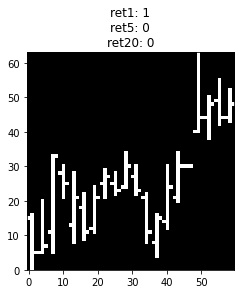

In [10]:
display_image(image_set[0])